In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Importing libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist       # MNIST dataset
from tensorflow.keras.models import Sequential    # Model architecture
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense  # CNN layers
from tensorflow.keras.utils import to_categorical # One-hot encoding
from skimage.transform import rotate  
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
import random

2025-06-08 08:27:43.376951: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749371263.568830      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749371263.623069      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Importing dataset

In [3]:
# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Normalize pixel values to [0, 1] and reshape for CNN input (28x28x1)
X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
X_test = X_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0


# Convert labels to one-hot encoding (e.g., "5" becomes [0,0,0,0,0,1,0,0,0,0])
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


# Base model
Building a simple CNN for MNIST image classification. The network is as simple as necesary

In [4]:
def build_smallnet():
    """A lightweight CNN for MNIST classification."""
    model = Sequential([
        # First convolutional layer: 32 filters, 3x3 kernel
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        # Downsample with max pooling
        MaxPooling2D((2, 2)),
        # Second convolutional layer: 64 filters, 3x3 kernel
        Conv2D(64, (3, 3), activation='relu'),
        # Downsample again
        MaxPooling2D((2, 2)),
        # Flatten 2D features to 1D for dense layers
        Flatten(),
        # Fully connected layer with 64 neurons
        Dense(64, activation='relu'),
        # Output layer (10 classes for digits 0-9)
        Dense(10, activation='softmax')
    ])
    
    # Compile the model with Adam optimizer and cross-entropy loss
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Evaluation and Plotting Function

## Rotation Evaluation

In [6]:
# ----------------------------
# 3. Rotation Accuracy Evaluator
# ----------------------------
def evaluate_rotation_impact(model, X_test, y_test, max_angle=100, step=1):
    """
    Evaluates model accuracy across rotation angles (0° to max_angle).
    
    Args:
        model: Trained Keras model
        X_test: Test images
        y_test: Test labels
        max_angle: Maximum rotation angle (default: 100°)
        step: Angle increment step (default: 1°)
    
    Returns:
        results: Dictionary {angle: accuracy}
        critical_angle: First angle where accuracy drops below 90%
    """
    angles = range(0, max_angle + 1, step)
    results = {}
    critical_angle = None
    
    for angle in angles:
        # Rotate images with nearest-neighbor interpolation
        X_rotated = np.array([rotate(img.squeeze(), angle, order=0, preserve_range=True) 
                             for img in X_test])
        X_rotated = X_rotated.reshape(-1, 28, 28, 1)
        
        # Evaluate accuracy
        _, acc = model.evaluate(X_rotated, y_test, verbose=0)
        results[angle] = acc
    
    return results

## Translation Evaluation

In [146]:
def evaluate_translation_impact(model, X_test, y_test, max_translation=15, step=1):
    """
    Evaluates model accuracy across translation amounts (0px to max_translation) with wrap-around.
    
    Args:
        model: Trained Keras model
        X_test: Test images
        y_test: Test labels
        max_translation: Maximum translation in pixels (default: 15px)
        step: Translation increment step (default: 1px)
    
    Returns:
        results: Dictionary {translation: accuracy}
        critical_translation: First translation where accuracy drops below 90%
    """
    translations = range(0, max_translation + 1, step)
    results = {}
    critical_translation = None
    
    for tx in translations:
        # Apply horizontal translation with wrap-around
        X_translated = np.array([np.roll(img.squeeze(), shift=tx, axis=1) for img in X_test])
        X_translated = X_translated.reshape(-1, 28, 28, 1)
        
        # Get predictions
        y_pred = model.predict(X_translated, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)
        
        # Calculate accuracy
        if len(y_test.shape) > 1:  # if one-hot encoded
            y_true = np.argmax(y_test, axis=1)
        else:
            y_true = y_test
        acc = accuracy_score(y_true, y_pred_classes)
        results[tx] = acc
    
    return results

## Rotation Plotting

In [7]:
# ----------------------------
# 4. Visualize Results
# ----------------------------
def plot_rotation_impact(results, critical_angle=None):
    angles = list(results.keys())
    accuracies = list(results.values())
    
    plt.figure(figsize=(12, 6))
    plt.plot(angles, accuracies, 'b-', linewidth=2, label='Accuracy')
    plt.axhline(y=0.85, color='r', linestyle='--', label='90% Threshold')
    
    if critical_angle:
        plt.axvline(x=critical_angle, color='g', linestyle='--', 
                   label=f'Critical Angle: {critical_angle}°')
    
    plt.title('Model Accuracy vs Image Rotation Angle', fontsize=14)
    plt.xlabel('Rotation Angle (degrees)', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.ylim(0, 1.0)
    plt.xticks(np.arange(0, 101, 10))
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

#  Task 1
* Develop a model to classify images from the MNIST datase (60,000 training, 10,000 test samples)
* Train the model to recognize rotated digit images
* Create 10 specialized models, each trained on images rotated within 10° ranges (0°-10°, 10°-20°, ..., 90°-100°)
* Evaluate all models on test images rotated from 0° to 100°
* Plot each model’s classification accuracy (Figures 1 and 2)


## Setting training sets
Since we train different models, we preprocess different training set for these.

In [61]:
## training for angle in the range [0,10]
angle_1 = list()
X_temp = list()
for i in range(0,X_train.shape[0]):
    angle = int(random.uniform(0,10))
    X_temp.append(rotate(X_train[i],angle,preserve_range=True, order=0))
    angle_1.append(angle)
X_train_1 = np.array(X_temp).reshape(-1, 28, 28, 1)

## training for angle in the range [10,20]

angle_2 = list()
X_temp = list()
for i in range(0,X_train.shape[0]):
    angle = int(random.uniform(10,20))
    X_temp.append(rotate(X_train[i],angle,preserve_range=True, order=0))
    angle_2.append(angle)
X_train_2 = np.array(X_temp).reshape(-1, 28, 28, 1)

## training for angle in the range [20,30]

angle_3 = list()
X_temp = list()
for i in range(0,X_train.shape[0]):
    angle = int(random.uniform(20,30))
    X_temp.append(rotate(X_train[i],angle,preserve_range=True, order=0))
    angle_3.append(angle)
X_train_3 = np.array(X_temp).reshape(-1, 28, 28, 1)

## training for angle in the range [30,40]

angle_4 = list()
X_temp = list()
for i in range(0,X_train.shape[0]):
    angle = int(random.uniform(30,40))
    X_temp.append(rotate(X_train[i],angle,preserve_range=True, order=0))
    angle_4.append(angle)
X_train_4 = np.array(X_temp).reshape(-1, 28, 28, 1)

## training for angle in the range [40,50]

angle_5 = list()
X_temp = list()
for i in range(0,X_train.shape[0]):
    angle = int(random.uniform(40,50))
    X_temp.append(rotate(X_train[i],angle,preserve_range=True, order=0))
    angle_5.append(angle)
X_train_5 = np.array(X_temp).reshape(-1, 28, 28, 1)

## training for angle in the range [50,60]

angle_6 = list()
X_temp = list()
for i in range(0,X_train.shape[0]):
    angle = int(random.uniform(50,60))
    X_temp.append(rotate(X_train[i],angle,preserve_range=True, order=0))
    angle_6.append(angle)
X_train_6 = np.array(X_temp).reshape(-1, 28, 28, 1)

## training for angle in the range [60,70]

angle_7 = list()
X_temp = list()
for i in range(0,X_train.shape[0]):
    angle = int(random.uniform(60,70))
    X_temp.append(rotate(X_train[i],angle,preserve_range=True, order=0))
    angle_7.append(angle)
X_train_7 = np.array(X_temp).reshape(-1, 28, 28, 1)

## training for angle in the range [70,80]

angle_8 = list()
X_temp = list()
for i in range(0,X_train.shape[0]):
    angle = int(random.uniform(70,80))
    X_temp.append(rotate(X_train[i],angle,preserve_range=True, order=0))
    angle_8.append(angle)
X_train_8 = np.array(X_temp).reshape(-1, 28, 28, 1)

## training for angle in the range [80,90]

angle_9 = list()
X_temp = list()
for i in range(0,X_train.shape[0]):
    angle = int(random.uniform(80,90))
    X_temp.append(rotate(X_train[i],angle,preserve_range=True, order=0))
    angle_9.append(angle)
X_train_9 = np.array(X_temp).reshape(-1, 28, 28, 1)

## training for angle in the range [90,100]

angle_X = list()
X_temp = list()
for i in range(0,X_train.shape[0]):
    angle = int(random.uniform(90,100))
    X_temp.append(rotate(X_train[i],angle,preserve_range=True, order=0))
    angle_X.append(angle)
X_train_X = np.array(X_temp).reshape(-1, 28, 28, 1)

## Building Models
We build the models based on the function defined above for each range of angle

In [62]:
## training for angle in the range [0,10]
model_1 = build_enhanced_net()
history_1 = model_1.fit(X_train_1, y_train, epochs=5, batch_size=64, validation_split=0.2)

## training for angle in the range [10,20]

model_2 = build_smallnet()
history_2 = model_2.fit(X_train_2, y_train, epochs=5, batch_size=64, validation_split=0.2)

## training for angle in the range [20,30]

model_3 = build_smallnet()
history_3 = model_3.fit(X_train_3, y_train, epochs=5, batch_size=64, validation_split=0.2)

## training for angle in the range [30,40]

model_4 = build_smallnet()
history_4 = model_4.fit(X_train_4, y_train, epochs=5, batch_size=64, validation_split=0.2)

## training for angle in the range [40,50]

model_5 = build_smallnet()
history_5 = model_5.fit(X_train_5, y_train, epochs=5, batch_size=64, validation_split=0.2)

## training for angle in the range [50,60]

model_6 = build_smallnet()
history_6 = model_6.fit(X_train_6, y_train, epochs=5, batch_size=64, validation_split=0.2)

## training for angle in the range [60,70]

model_7 = build_smallnet()
history_7 = model_7.fit(X_train_7, y_train, epochs=5, batch_size=64, validation_split=0.2)

## training for angle in the range [70,80]

model_8 = build_smallnet()
history_8 = model_8.fit(X_train_8, y_train, epochs=5, batch_size=64, validation_split=0.2)


## training for angle in the range [80,90]

model_9 = build_smallnet()
history_9 = model_9.fit(X_train_9, y_train, epochs=5, batch_size=64, validation_split=0.2)

## training for angle in the range [90,100]

model_X = build_smallnet()
history_X = model_X.fit(X_train_X, y_train, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.6843 - loss: 1.7808 - val_accuracy: 0.9814 - val_loss: 0.5845
Epoch 2/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9622 - loss: 0.5854 - val_accuracy: 0.9819 - val_loss: 0.3362
Epoch 3/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9725 - loss: 0.3279 - val_accuracy: 0.9834 - val_loss: 0.2092
Epoch 4/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9782 - loss: 0.2150 - val_accuracy: 0.9872 - val_loss: 0.1545
Epoch 5/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9813 - loss: 0.1697 - val_accuracy: 0.9902 - val_loss: 0.1298


## Evaluation

In [63]:
## training for angle in the range [0,10]
accuracy_results_1 = evaluate_rotation_impact(model_1, X_test[:2500], y_test[:2500])

## training for angle in the range [10,20]

accuracy_results_2 = evaluate_rotation_impact(model_2, X_test[:2500], y_test[:2500])

## training for angle in the range [20,30]

accuracy_results_3 = evaluate_rotation_impact(model_3, X_test[:2500], y_test[:2500])

## training for angle in the range [30,40]

accuracy_results_4 = evaluate_rotation_impact(model_4, X_test[:2500], y_test[:2500])

## training for angle in the range [40,50]

accuracy_results_5 = evaluate_rotation_impact(model_5, X_test[:2500], y_test[:2500])

## training for angle in the range [50,60]

accuracy_results_6 = evaluate_rotation_impact(model_6, X_test[:2500], y_test[:2500])

## training for angle in the range [60,70]

accuracy_results_7 = evaluate_rotation_impact(model_7, X_test[:2500], y_test[:2500])

## training for angle in the range [70,80]

accuracy_results_8 = evaluate_rotation_impact(model_8, X_test[:2500], y_test[:2500])

## training for angle in the range [80,90]

accuracy_results_9 = evaluate_rotation_impact(model_9, X_test[:2500], y_test[:2500])

## training for angle in the range [90,100]

accuracy_results_X = evaluate_rotation_impact(model_X, X_test[:2500], y_test[:2500])

# Results for Task 1

## Ensemble plots

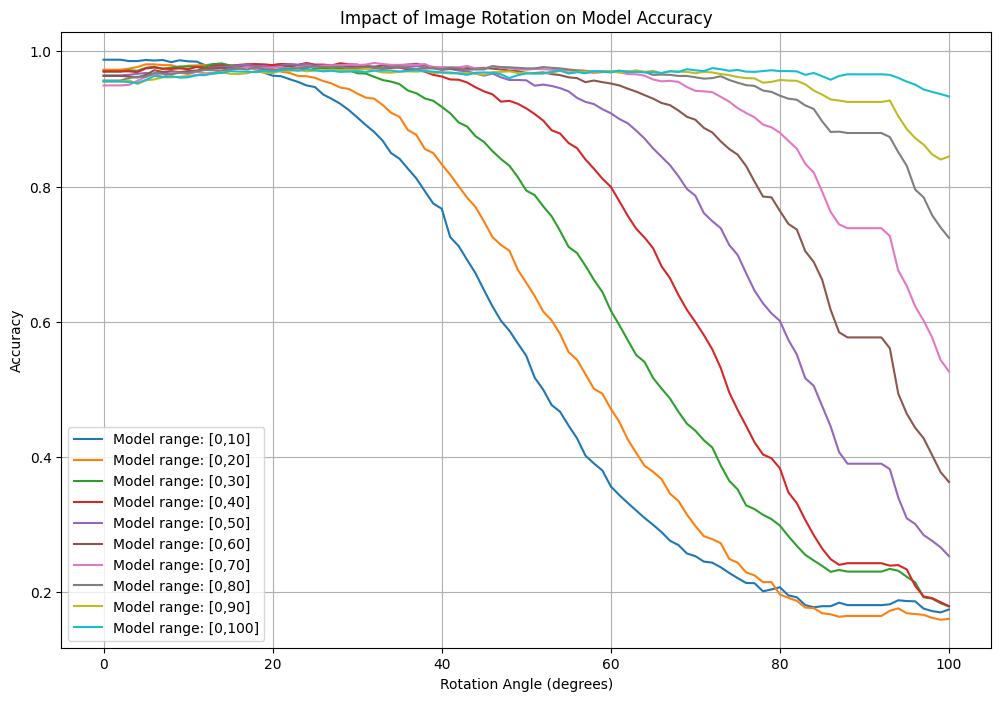

In [91]:
# Create a new figure
plt.figure(figsize=(12, 8))

# List of all your accuracy results
all_results = [
    accuracy_results_1, accuracy_results_2, accuracy_results_3,
    accuracy_results_4, accuracy_results_5, accuracy_results_6,
    accuracy_results_7, accuracy_results_8, accuracy_results_9, accuracy_results_X
]

# Plot each one
labels = ['Model range: [0,10]', 'Model range: [10,20]', 'Model range: [20,30]', 'Model range: [30,40]', 'Model range: [40,50]',
          'Model range: [50,60]', 'Model range: [60,70]', 'Model range: [70,80]', 'Model range: [80,90]', 'Model range: [90,100]']
for i, results in enumerate(all_results):
    rotations = list(results.keys())
    accuracies = list(results.values())
    plt.plot(rotations, accuracies, label=labels[i])

plt.xlabel('Rotation Angle (degrees)')
plt.ylabel('Accuracy')
plt.title('Impact of Image Rotation on Model Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Seperated plots

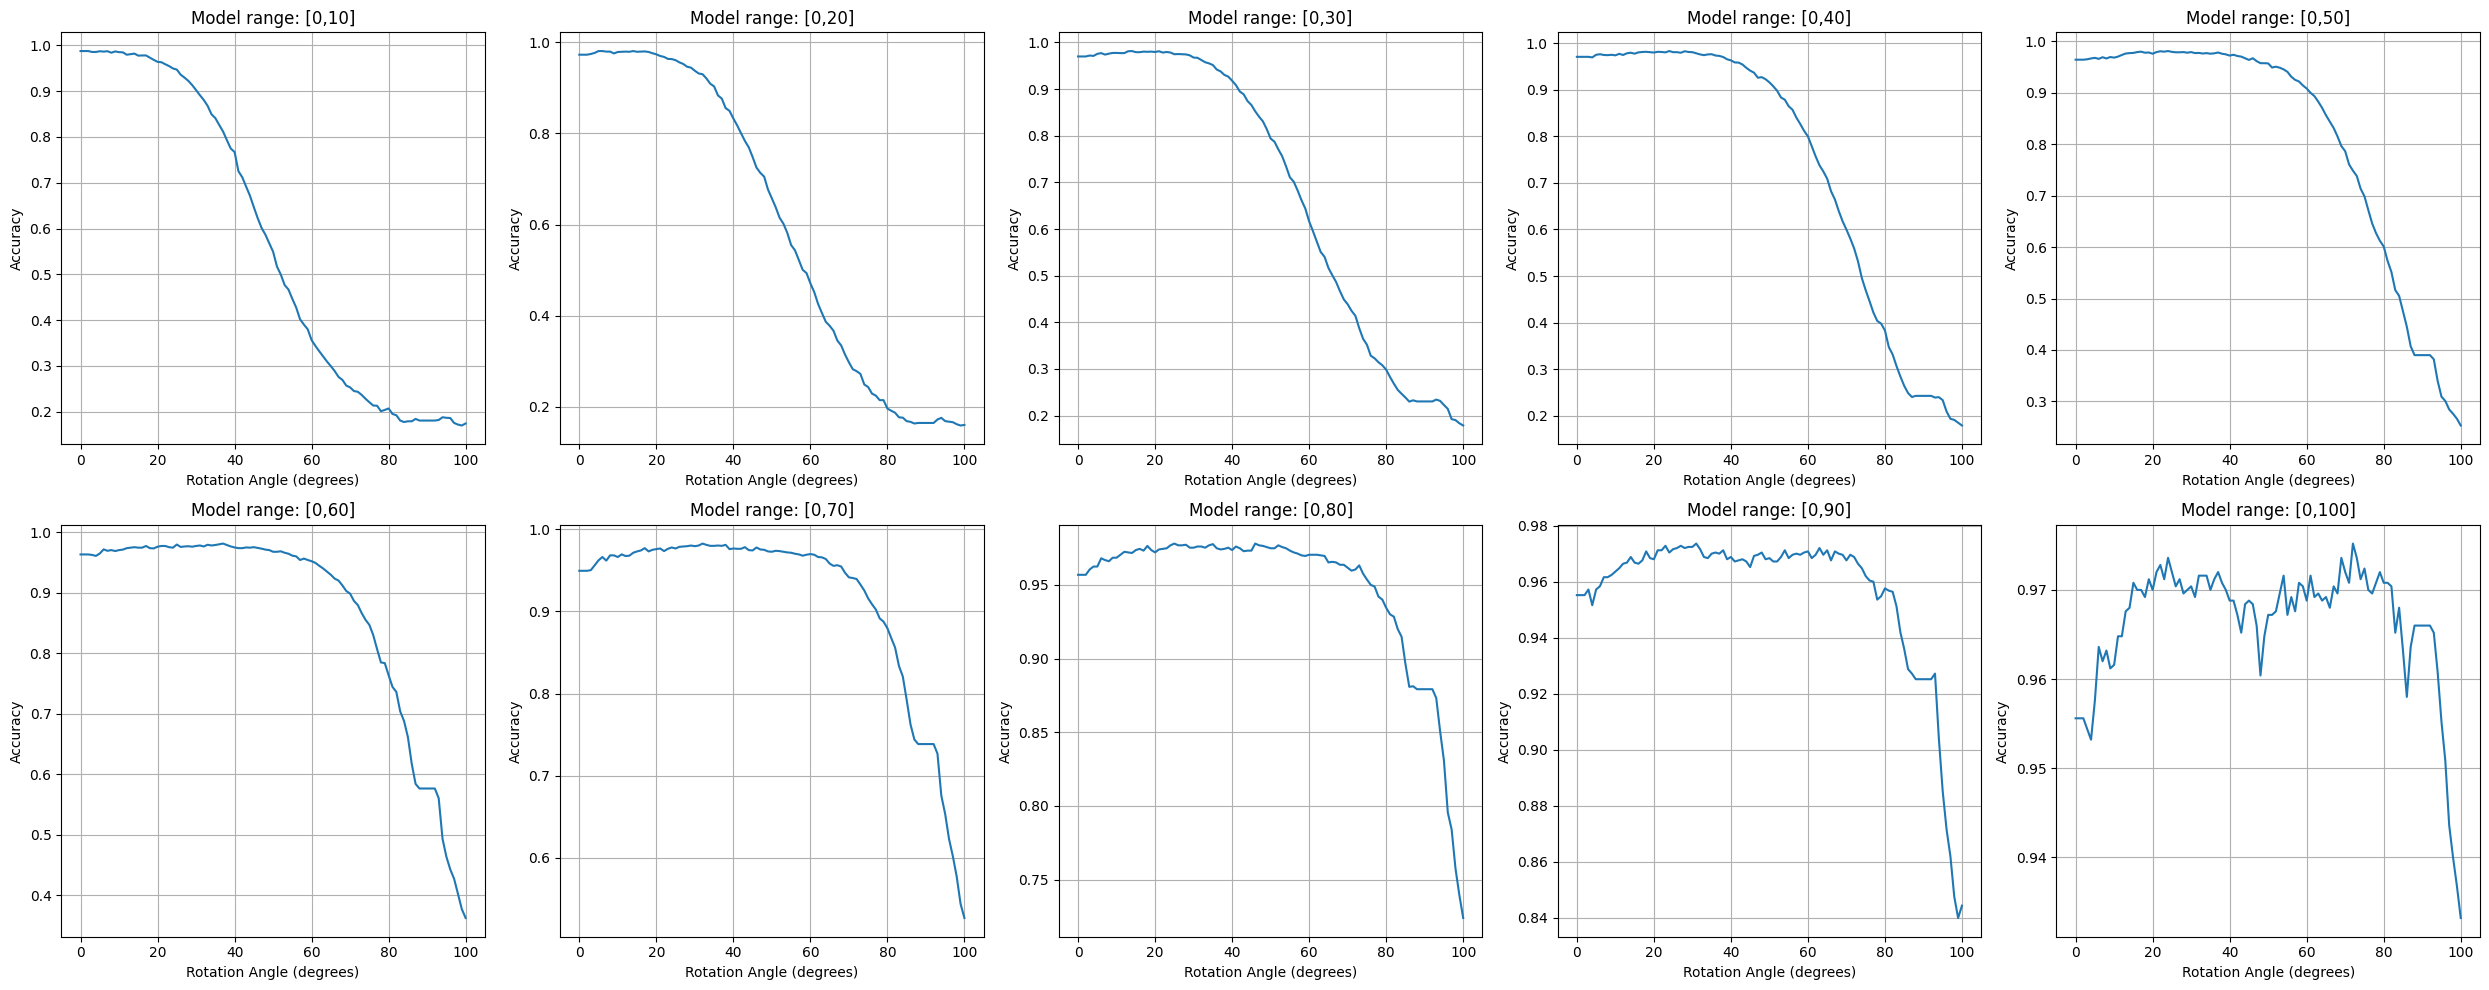

In [92]:
# List of all your accuracy results and their labels
all_results = [
    accuracy_results_1, accuracy_results_2, accuracy_results_3,
    accuracy_results_4, accuracy_results_5, accuracy_results6,
    accuracy_results_7, accuracy_results_8, accuracy_results_9, accuracy_results_X
]
labels = ['Model range: [0,10]', 'Model range: [10,20]', 'Model range: [20,30]', 'Model range: [30,40]', 'Model range: [40,50]',
          'Model range: [50,60]', 'Model range: [60,70]', 'Model range: [70,80]', 'Model range: [80,90]', 'Model range: [90,100]']

# Create a 2x5 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each dataset in its own subplot
for i, (results, label) in enumerate(zip(all_results, labels)):
    rotations = list(results.keys())
    accuracies = list(results.values())

    axes[i].plot(rotations, accuracies)
    axes[i].set_title(label)
    axes[i].set_xlabel('Rotation Angle (degrees)')
    axes[i].set_ylabel('Accuracy')
    axes[i].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Task 2
* Follows the same methodology as Task 1
* Train models on progressively larger rotation ranges (0°–10°,0°–20°, ..., 0°–100°)
* Plot model accuracy curves (Figures 3 and 4)

## Setting training sets
Since we train different models, we preprocess different training set for these.

In [61]:
## training for angle in the range [0,10]
angle1 = list()
X_temp = list()
for i in range(0,X_train.shape[0]):
    angle = int(random.uniform(0,10))
    X_temp.append(rotate(X_train[i],angle,preserve_range=True, order=0))
    angle1.append(angle)
X_train1 = np.array(X_temp).reshape(-1, 28, 28, 1)

## training for angle in the range [0,20]

angle2 = list()
X_temp = list()
for i in range(0,X_train.shape[0]):
    angle = int(random.uniform(0,20))
    X_temp.append(rotate(X_train[i],angle,preserve_range=True, order=0))
    angle2.append(angle)
X_train2 = np.array(X_temp).reshape(-1, 28, 28, 1)

## training for angle in the range [0,30]

angle3 = list()
X_temp = list()
for i in range(0,X_train.shape[0]):
    angle = int(random.uniform(0,30))
    X_temp.append(rotate(X_train[i],angle,preserve_range=True, order=0))
    angle3.append(angle)
X_train3 = np.array(X_temp).reshape(-1, 28, 28, 1)

## training for angle in the range [0,40]

angle4 = list()
X_temp = list()
for i in range(0,X_train.shape[0]):
    angle = int(random.uniform(0,40))
    X_temp.append(rotate(X_train[i],angle,preserve_range=True, order=0))
    angle4.append(angle)
X_train4 = np.array(X_temp).reshape(-1, 28, 28, 1)

## training for angle in the range [0,50]

angle5 = list()
X_temp = list()
for i in range(0,X_train.shape[0]):
    angle = int(random.uniform(0,50))
    X_temp.append(rotate(X_train[i],angle,preserve_range=True, order=0))
    angle5.append(angle)
X_train5 = np.array(X_temp).reshape(-1, 28, 28, 1)

## training for angle in the range [0,60]

angle6 = list()
X_temp = list()
for i in range(0,X_train.shape[0]):
    angle = int(random.uniform(0,60))
    X_temp.append(rotate(X_train[i],angle,preserve_range=True, order=0))
    angle6.append(angle)
X_train6 = np.array(X_temp).reshape(-1, 28, 28, 1)

## training for angle in the range [0,70]

angle7 = list()
X_temp = list()
for i in range(0,X_train.shape[0]):
    angle = int(random.uniform(0,70))
    X_temp.append(rotate(X_train[i],angle,preserve_range=True, order=0))
    angle7.append(angle)
X_train7 = np.array(X_temp).reshape(-1, 28, 28, 1)

## training for angle in the range [0,80]

angle8 = list()
X_temp = list()
for i in range(0,X_train.shape[0]):
    angle = int(random.uniform(0,80))
    X_temp.append(rotate(X_train[i],angle,preserve_range=True, order=0))
    angle8.append(angle)
X_train8 = np.array(X_temp).reshape(-1, 28, 28, 1)

## training for angle in the range [0,90]

angle9 = list()
X_temp = list()
for i in range(0,X_train.shape[0]):
    angle = int(random.uniform(0,90))
    X_temp.append(rotate(X_train[i],angle,preserve_range=True, order=0))
    angle9.append(angle)
X_train9 = np.array(X_temp).reshape(-1, 28, 28, 1)

## training for angle in the range [0,100]

angleX = list()
X_temp = list()
for i in range(0,X_train.shape[0]):
    angle = int(random.uniform(0,100))
    X_temp.append(rotate(X_train[i],angle,preserve_range=True, order=0))
    angleX.append(angle)
X_trainX = np.array(X_temp).reshape(-1, 28, 28, 1)

## Building Models
We build the models based on the function defined above for each range of angle

In [62]:
## training for angle in the range [0,10]
model1 = build_enhanced_net()
history1 = model1.fit(X_train1, y_train, epochs=5, batch_size=64, validation_split=0.2)

## training for angle in the range [0,20]

model2 = build_smallnet()
history2 = model2.fit(X_train2, y_train, epochs=5, batch_size=64, validation_split=0.2)

## training for angle in the range [0,30]

model3 = build_smallnet()
history3 = model3.fit(X_train3, y_train, epochs=5, batch_size=64, validation_split=0.2)

## training for angle in the range [0,40]

model4 = build_smallnet()
history4 = model4.fit(X_train4, y_train, epochs=5, batch_size=64, validation_split=0.2)

## training for angle in the range [0,50]

model5 = build_smallnet()
history5 = model5.fit(X_train5, y_train, epochs=5, batch_size=64, validation_split=0.2)

## training for angle in the range [0,60]

model6 = build_smallnet()
history6 = model6.fit(X_train6, y_train, epochs=5, batch_size=64, validation_split=0.2)

## training for angle in the range [0,70]

model7 = build_smallnet()
history7 = model7.fit(X_train7, y_train, epochs=5, batch_size=64, validation_split=0.2)

## training for angle in the range [0,80]

model8 = build_smallnet()
history8 = model8.fit(X_train8, y_train, epochs=5, batch_size=64, validation_split=0.2)


## training for angle in the range [0,90]

model9 = build_smallnet()
history9 = model9.fit(X_train9, y_train, epochs=5, batch_size=64, validation_split=0.2)

## training for angle in the range [0,100]

modelX = build_smallnet()
historyX = modelX.fit(X_trainX, y_train, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.6843 - loss: 1.7808 - val_accuracy: 0.9814 - val_loss: 0.5845
Epoch 2/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9622 - loss: 0.5854 - val_accuracy: 0.9819 - val_loss: 0.3362
Epoch 3/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9725 - loss: 0.3279 - val_accuracy: 0.9834 - val_loss: 0.2092
Epoch 4/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9782 - loss: 0.2150 - val_accuracy: 0.9872 - val_loss: 0.1545
Epoch 5/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9813 - loss: 0.1697 - val_accuracy: 0.9902 - val_loss: 0.1298


## Evaluation

In [63]:
## training for angle in the range [0,10]
accuracy_results1 = evaluate_rotation_impact(model1, X_test[:2500], y_test[:2500])

## training for angle in the range [0,20]

accuracy_results2 = evaluate_rotation_impact(model2, X_test[:2500], y_test[:2500])

## training for angle in the range [0,30]

accuracy_results3 = evaluate_rotation_impact(model3, X_test[:2500], y_test[:2500])

## training for angle in the range [0,40]

accuracy_results4 = evaluate_rotation_impact(model4, X_test[:2500], y_test[:2500])

## training for angle in the range [0,50]

accuracy_results5 = evaluate_rotation_impact(model5, X_test[:2500], y_test[:2500])

## training for angle in the range [0,60]

accuracy_results6 = evaluate_rotation_impact(model6, X_test[:2500], y_test[:2500])

## training for angle in the range [0,70]

accuracy_results7 = evaluate_rotation_impact(model7, X_test[:2500], y_test[:2500])

## training for angle in the range [0,80]

accuracy_results8 = evaluate_rotation_impact(model8, X_test[:2500], y_test[:2500])

## training for angle in the range [0,90]

accuracy_results9 = evaluate_rotation_impact(model9, X_test[:2500], y_test[:2500])

## training for angle in the range [0,100]

accuracy_resultsX = evaluate_rotation_impact(modelX, X_test[:2500], y_test[:2500])

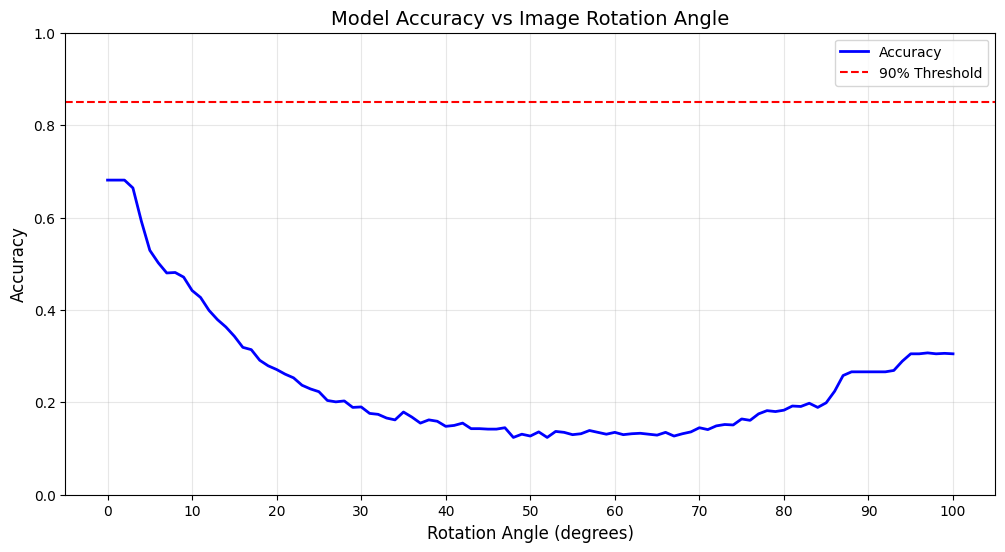

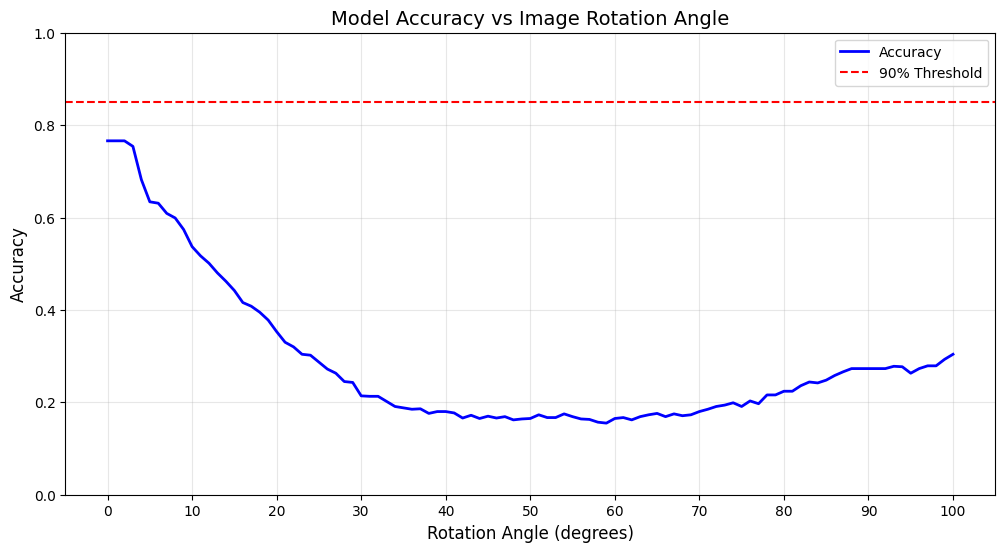

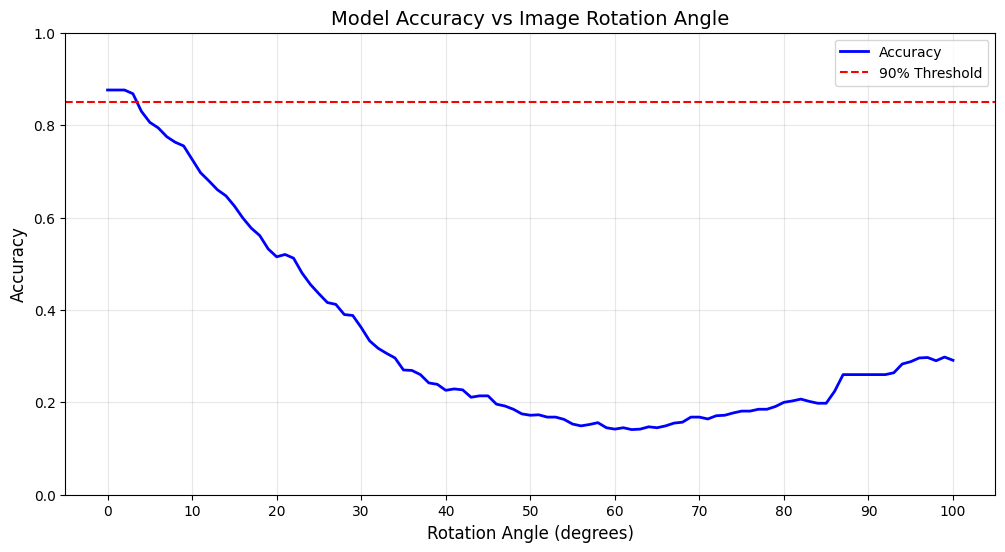

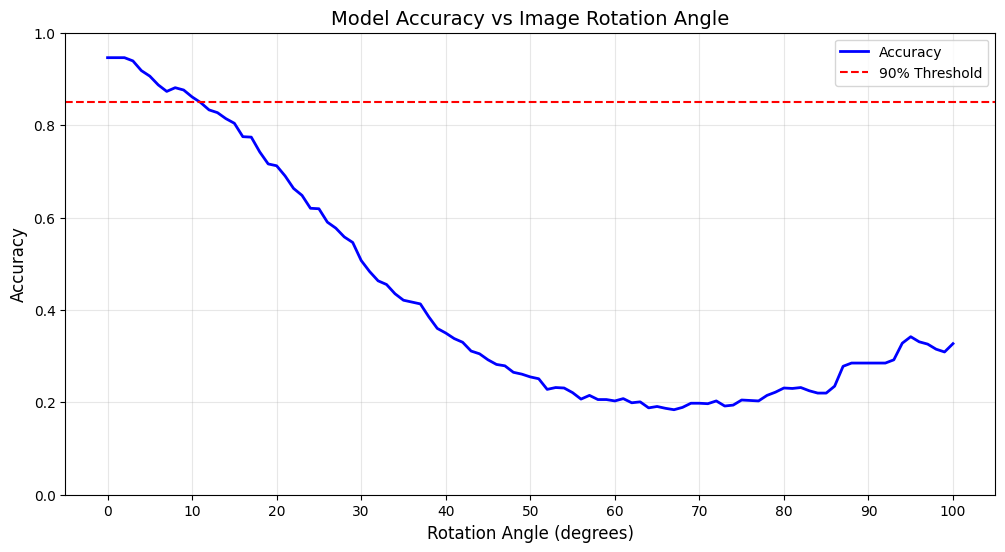

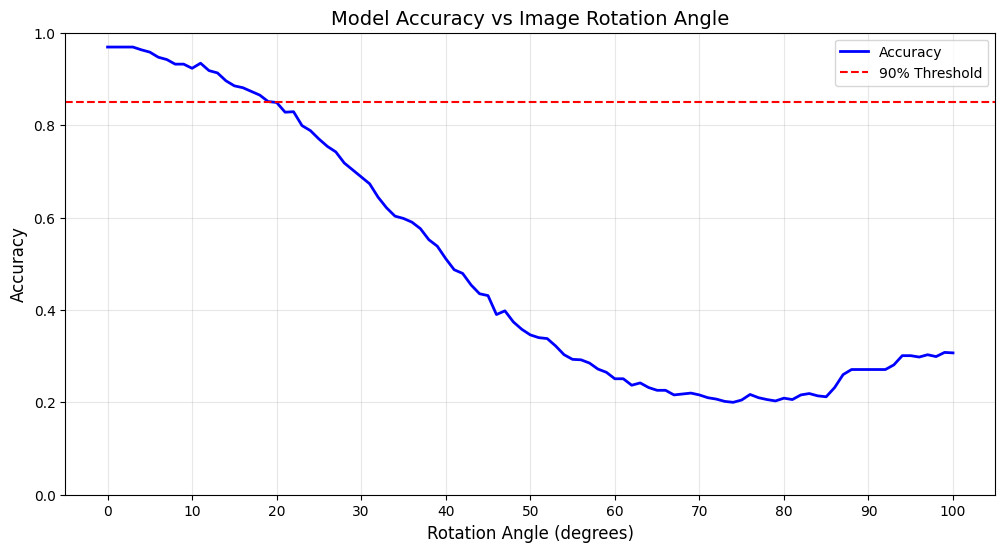

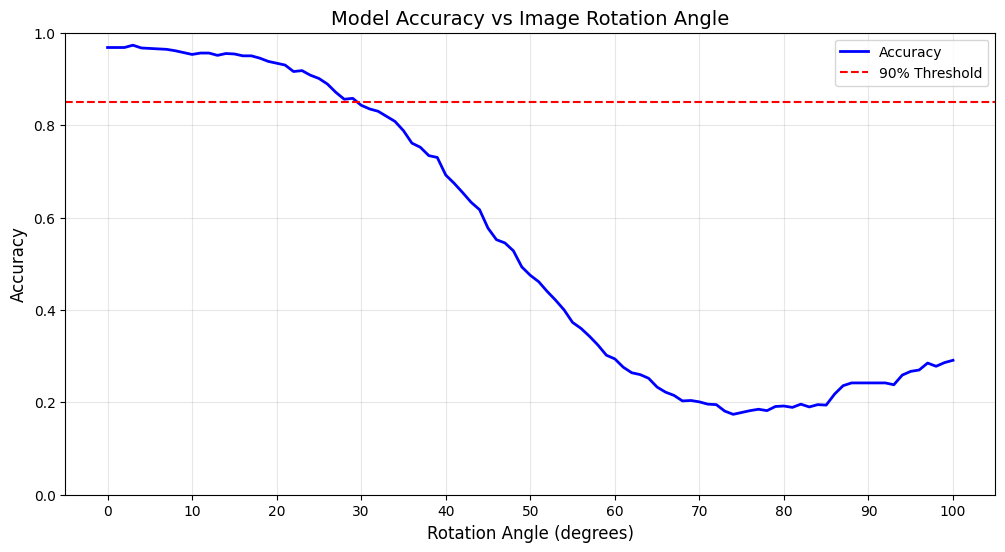

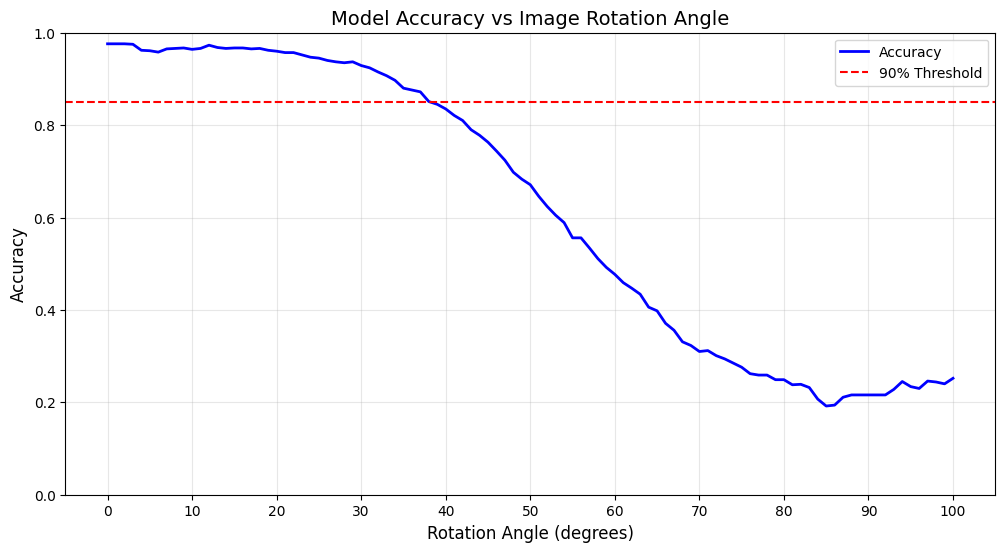

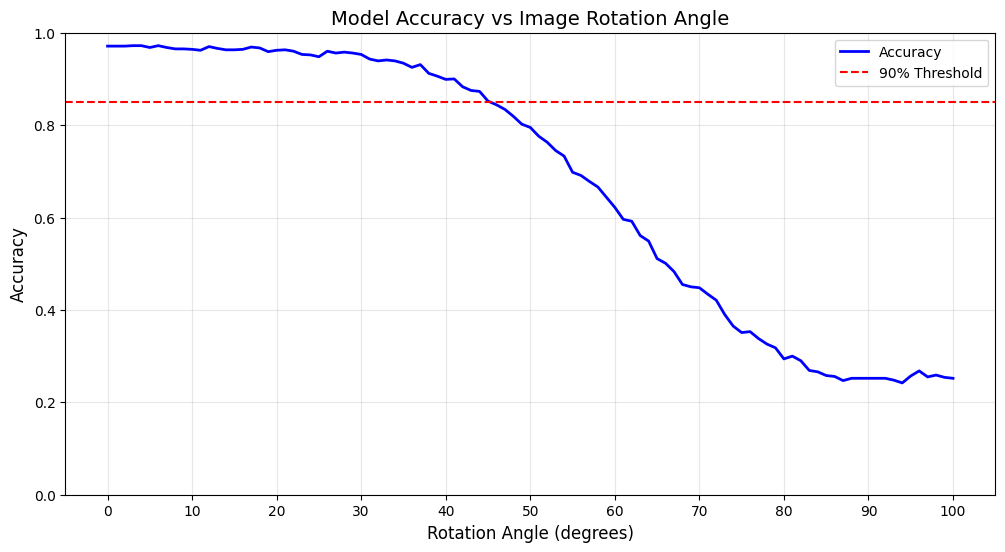

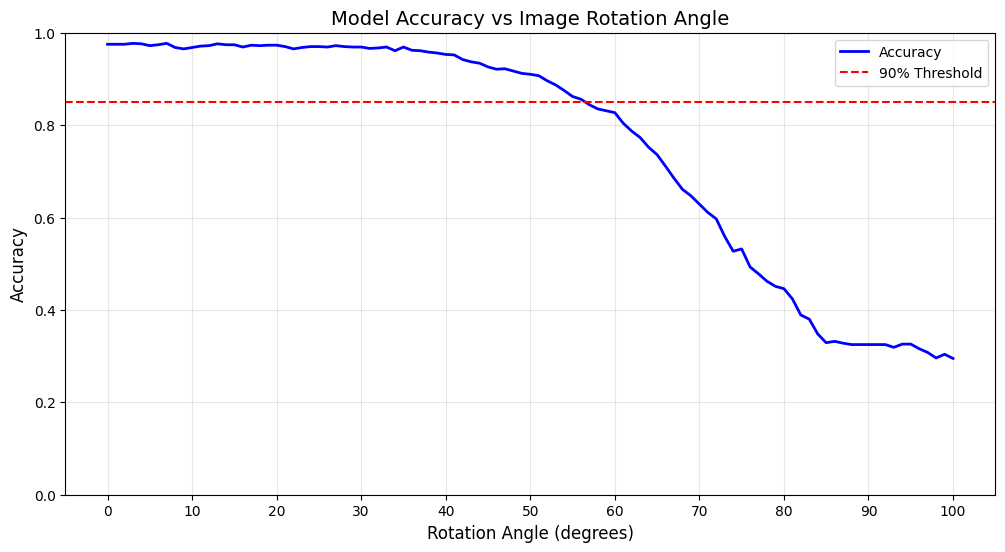

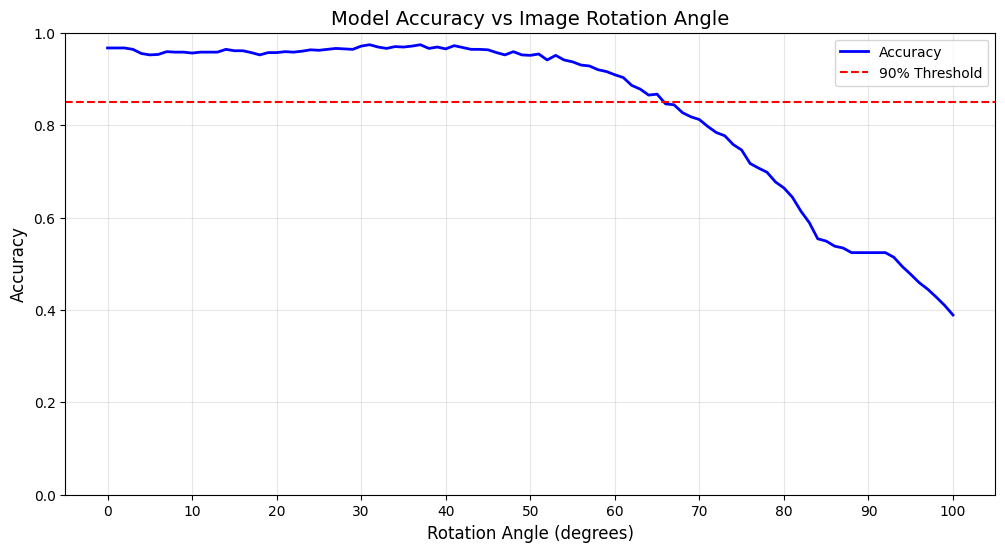

In [51]:
plot_rotation_impact(accuracy_results1)
plot_rotation_impact(accuracy_results2)
plot_rotation_impact(accuracy_results3)
plot_rotation_impact(accuracy_results4)
plot_rotation_impact(accuracy_results5)
plot_rotation_impact(accuracy_results6)
plot_rotation_impact(accuracy_results7)
plot_rotation_impact(accuracy_results8)
plot_rotation_impact(accuracy_results9)
plot_rotation_impact(accuracy_resultsX)

## Ensemble plots

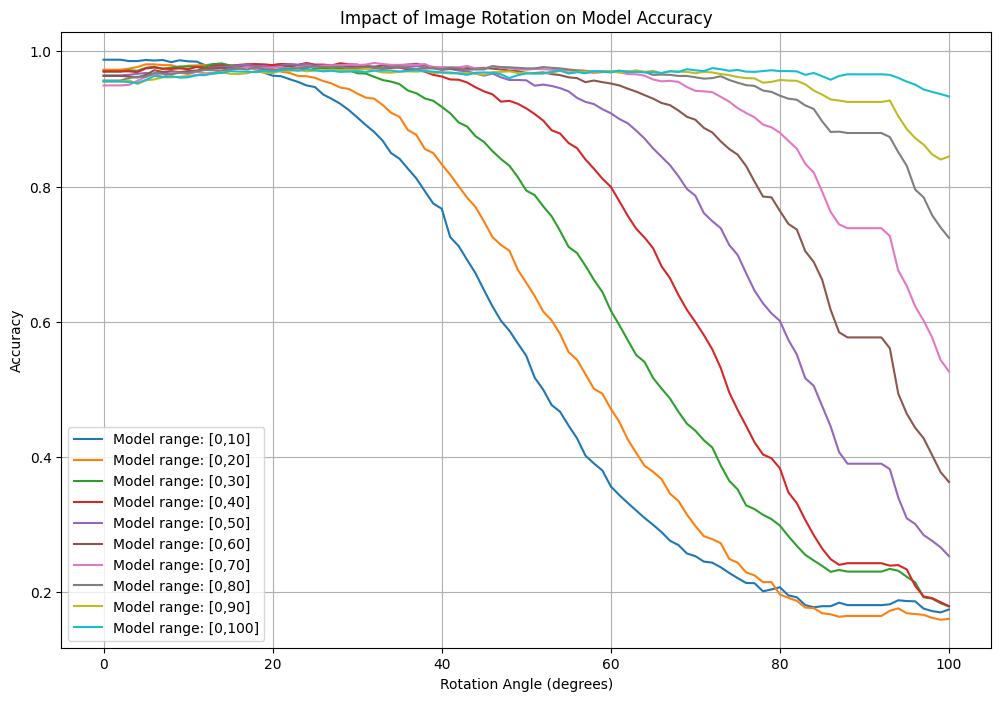

In [91]:
# Create a new figure
plt.figure(figsize=(12, 8))

# List of all your accuracy results
all_results = [
    accuracy_results1, accuracy_results2, accuracy_results3,
    accuracy_results4, accuracy_results5, accuracy_results6,
    accuracy_results7, accuracy_results8, accuracy_results9, accuracy_resultsX
]

# Plot each one
labels = ['Model range: [0,10]', 'Model range: [0,20]', 'Model range: [0,30]', 'Model range: [0,40]', 'Model range: [0,50]',
          'Model range: [0,60]', 'Model range: [0,70]', 'Model range: [0,80]', 'Model range: [0,90]', 'Model range: [0,100]']
for i, results in enumerate(all_results):
    rotations = list(results.keys())
    accuracies = list(results.values())
    plt.plot(rotations, accuracies, label=labels[i])

plt.xlabel('Rotation Angle (degrees)')
plt.ylabel('Accuracy')
plt.title('Impact of Image Rotation on Model Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Seperate Plots

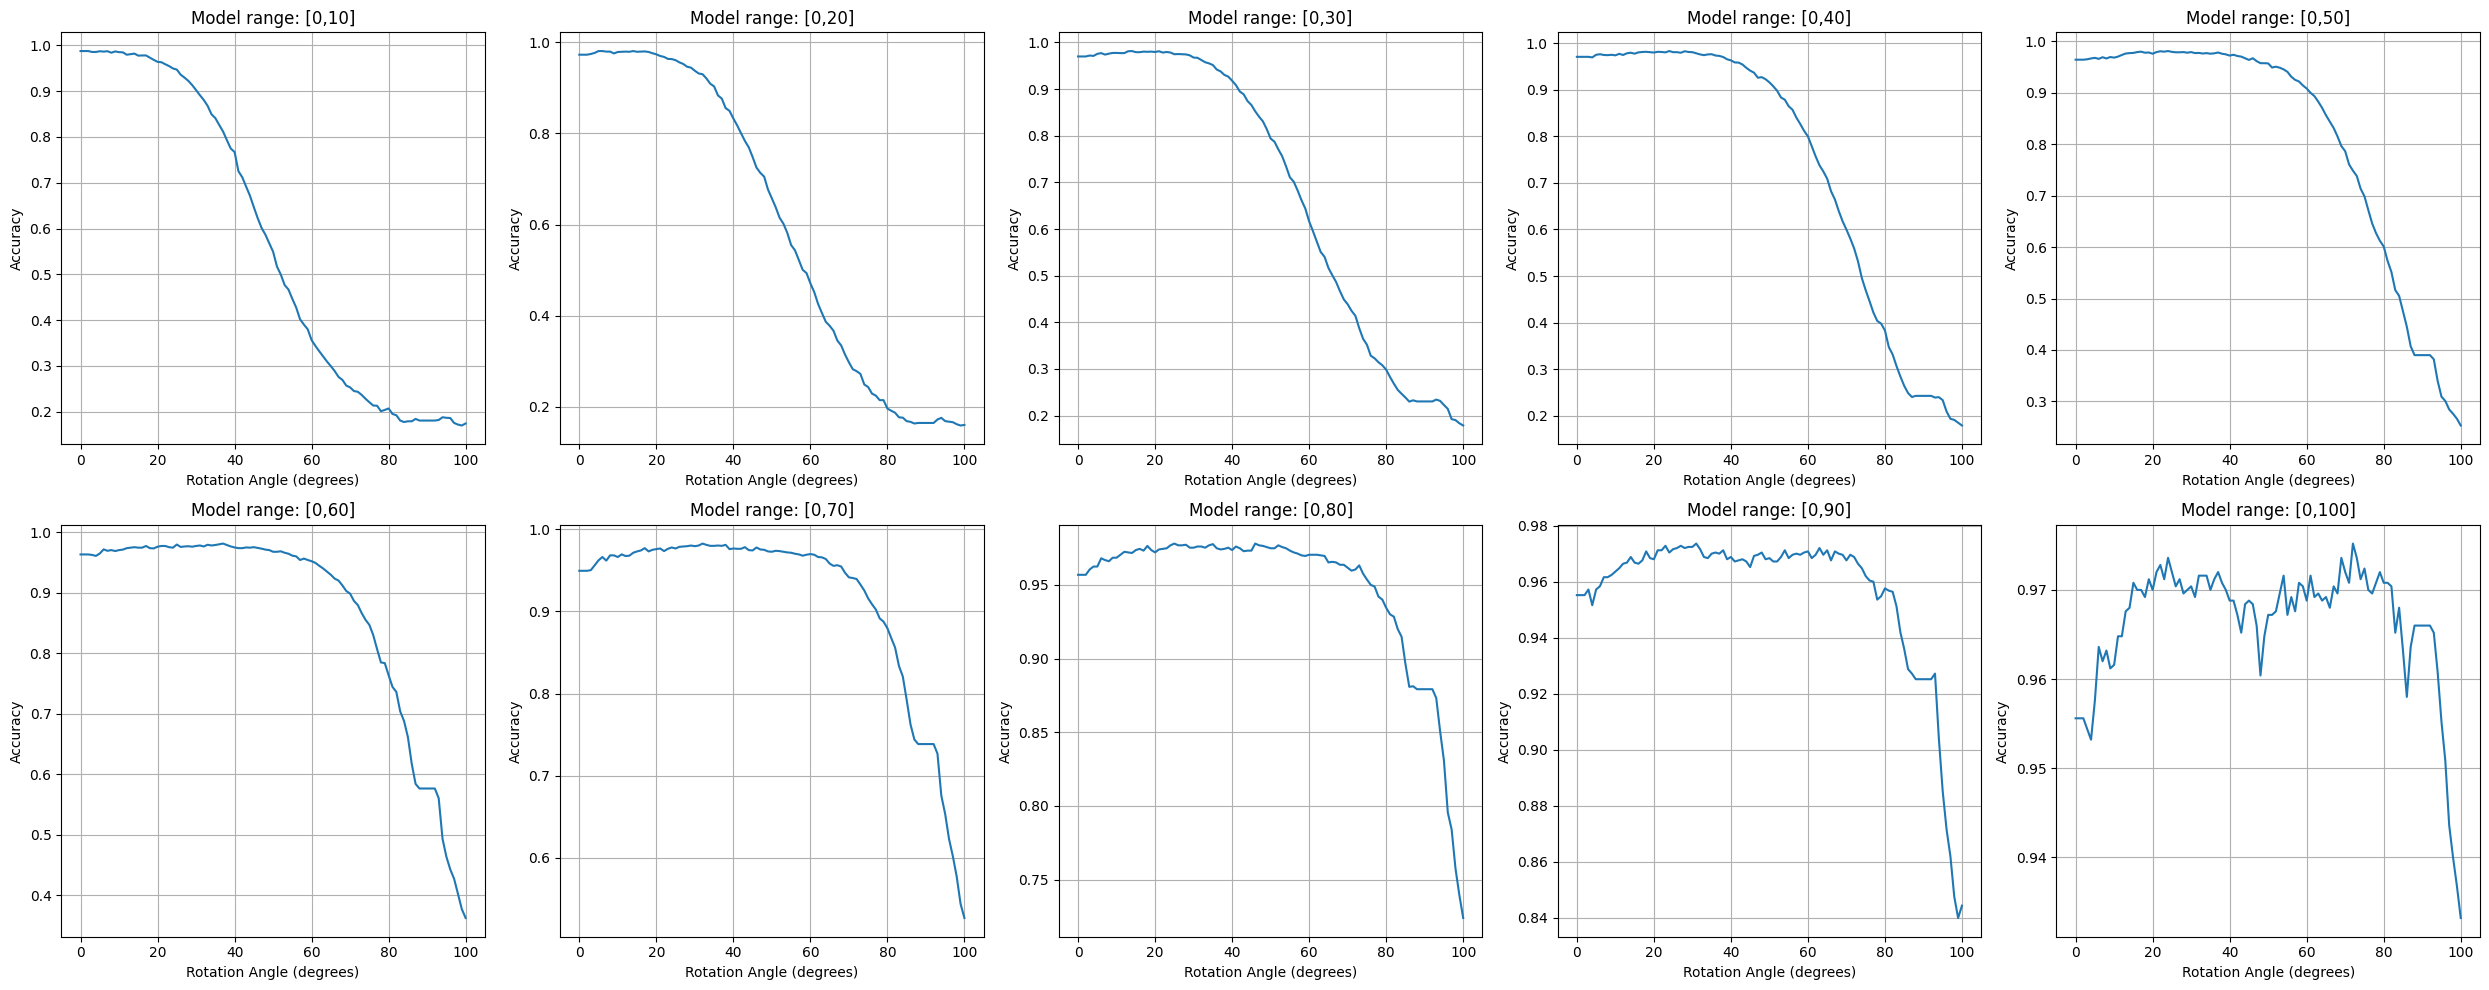

In [92]:
# List of all your accuracy results and their labels
all_results = [
    accuracy_results1, accuracy_results2, accuracy_results3,
    accuracy_results4, accuracy_results5, accuracy_results6,
    accuracy_results7, accuracy_results8, accuracy_results9, accuracy_resultsX
]
labels = ['Model range: [0,10]', 'Model range: [0,20]', 'Model range: [0,30]', 'Model range: [0,40]', 'Model range: [0,50]',
          'Model range: [0,60]', 'Model range: [0,70]', 'Model range: [0,80]', 'Model range: [0,90]', 'Model range: [0,100]']

# Create a 2x5 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each dataset in its own subplot
for i, (results, label) in enumerate(zip(all_results, labels)):
    rotations = list(results.keys())
    accuracies = list(results.values())

    axes[i].plot(rotations, accuracies)
    axes[i].set_title(label)
    axes[i].set_xlabel('Rotation Angle (degrees)')
    axes[i].set_ylabel('Accuracy')
    axes[i].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Angle [0,10] and [90,100]

In [93]:
angleX1 = list()
X_temp = list()
for i in range(0,X_train.shape[0]):
    unknown = int(random.uniform(1,3))
    if unknown ==1:
        angle = int(random.uniform(0,10))
    elif unknown ==2:
        angle = int(random.uniform(90,100))
    X_temp.append(rotate(X_train[i],angle,preserve_range=True, order=0))
    angleX1.append(angle)
X_trainX1 = np.array(X_temp).reshape(-1, 28, 28, 1)

In [94]:
modelX1 = build_smallnet()
historyX1 = modelX1.fit(X_trainX1, y_train, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7831 - loss: 0.6867 - val_accuracy: 0.9539 - val_loss: 0.1433
Epoch 2/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9590 - loss: 0.1349 - val_accuracy: 0.9680 - val_loss: 0.0966
Epoch 3/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9736 - loss: 0.0846 - val_accuracy: 0.9707 - val_loss: 0.0872
Epoch 4/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9828 - loss: 0.0553 - val_accuracy: 0.9778 - val_loss: 0.0715
Epoch 5/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9865 - loss: 0.0415 - val_accuracy: 0.9768 - val_loss: 0.0712


In [97]:
accuracy_resultsX1 = evaluate_rotation_impact(modelX1, X_test[:2500], y_test[:2500])

# Angle [10,20] and [80,90]

In [98]:
angleX2 = list()
X_temp = list()
for i in range(0,X_train.shape[0]):
    unknown = int(random.uniform(1,3))
    if unknown ==1:
        angle = int(random.uniform(10,20))
    elif unknown ==2:
        angle = int(random.uniform(80,90))
    X_temp.append(rotate(X_train[i],angle,preserve_range=True, order=0))
    angleX2.append(angle)
X_trainX2 = np.array(X_temp).reshape(-1, 28, 28, 1)

In [99]:
modelX2 = build_smallnet()
historyX2 = modelX2.fit(X_trainX2, y_train, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7809 - loss: 0.6837 - val_accuracy: 0.9558 - val_loss: 0.1369
Epoch 2/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9580 - loss: 0.1372 - val_accuracy: 0.9663 - val_loss: 0.1141
Epoch 3/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9722 - loss: 0.0891 - val_accuracy: 0.9728 - val_loss: 0.0851
Epoch 4/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9803 - loss: 0.0641 - val_accuracy: 0.9746 - val_loss: 0.0822
Epoch 5/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9848 - loss: 0.0476 - val_accuracy: 0.9754 - val_loss: 0.0829


In [100]:
accuracy_resultsX2 = evaluate_rotation_impact(modelX2, X_test[:2500], y_test[:2500])

# Angle [20,30] and [70,80]

In [101]:
angleX3 = list()
X_temp = list()
for i in range(0,X_train.shape[0]):
    unknown = int(random.uniform(1,3))
    if unknown ==1:
        angle = int(random.uniform(20,30))
    elif unknown ==2:
        angle = int(random.uniform(70,80))
    X_temp.append(rotate(X_train[i],angle,preserve_range=True, order=0))
    angleX3.append(angle)
X_trainX3 = np.array(X_temp).reshape(-1, 28, 28, 1)

In [102]:
modelX3 = build_smallnet()
historyX3 = modelX3.fit(X_trainX3, y_train, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8063 - loss: 0.6302 - val_accuracy: 0.9619 - val_loss: 0.1256
Epoch 2/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9621 - loss: 0.1234 - val_accuracy: 0.9690 - val_loss: 0.0970
Epoch 3/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9747 - loss: 0.0803 - val_accuracy: 0.9745 - val_loss: 0.0847
Epoch 4/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9810 - loss: 0.0578 - val_accuracy: 0.9774 - val_loss: 0.0768
Epoch 5/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9865 - loss: 0.0428 - val_accuracy: 0.9729 - val_loss: 0.0868


In [103]:
accuracy_resultsX3 = evaluate_rotation_impact(modelX3, X_test[:2500], y_test[:2500])

# Angle [30,40] and [60,70]

In [104]:
angleX4 = list()
X_temp = list()
for i in range(0,X_train.shape[0]):
    unknown = int(random.uniform(1,3))
    if unknown ==1:
        angle = int(random.uniform(30,40))
    elif unknown ==2:
        angle = int(random.uniform(60,70))
    X_temp.append(rotate(X_train[i],angle,preserve_range=True, order=0))
    angleX4.append(angle)
X_trainX4 = np.array(X_temp).reshape(-1, 28, 28, 1)

In [105]:
modelX4 = build_smallnet()
historyX = modelX4.fit(X_trainX4, y_train, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8166 - loss: 0.5788 - val_accuracy: 0.9638 - val_loss: 0.1191
Epoch 2/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9702 - loss: 0.0970 - val_accuracy: 0.9740 - val_loss: 0.0811
Epoch 3/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9779 - loss: 0.0702 - val_accuracy: 0.9778 - val_loss: 0.0714
Epoch 4/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9844 - loss: 0.0496 - val_accuracy: 0.9806 - val_loss: 0.0598
Epoch 5/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9881 - loss: 0.0387 - val_accuracy: 0.9783 - val_loss: 0.0689


In [106]:
accuracy_resultsX4 = evaluate_rotation_impact(modelX4, X_test[:2500], y_test[:2500])

# Angle [40,50] and [60,70]

In [107]:
angleX5 = list()
X_temp = list()
for i in range(0,X_train.shape[0]):
    unknown = int(random.uniform(1,3))
    if unknown ==1:
        angle = int(random.uniform(40,50))
    elif unknown ==2:
        angle = int(random.uniform(60,70))
    X_temp.append(rotate(X_train[i],angle,preserve_range=True, order=0))
    angleX5.append(angle)
X_trainX5 = np.array(X_temp).reshape(-1, 28, 28, 1)

In [108]:
modelX5 = build_smallnet()
historyX5 = modelX5.fit(X_trainX5, y_train, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8486 - loss: 0.5044 - val_accuracy: 0.9715 - val_loss: 0.0940
Epoch 2/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9729 - loss: 0.0867 - val_accuracy: 0.9758 - val_loss: 0.0763
Epoch 3/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9805 - loss: 0.0631 - val_accuracy: 0.9797 - val_loss: 0.0702
Epoch 4/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9865 - loss: 0.0447 - val_accuracy: 0.9826 - val_loss: 0.0597
Epoch 5/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9887 - loss: 0.0341 - val_accuracy: 0.9784 - val_loss: 0.0748


In [109]:
accuracy_resultsX5 = evaluate_rotation_impact(modelX5, X_test[:2500], y_test[:2500])

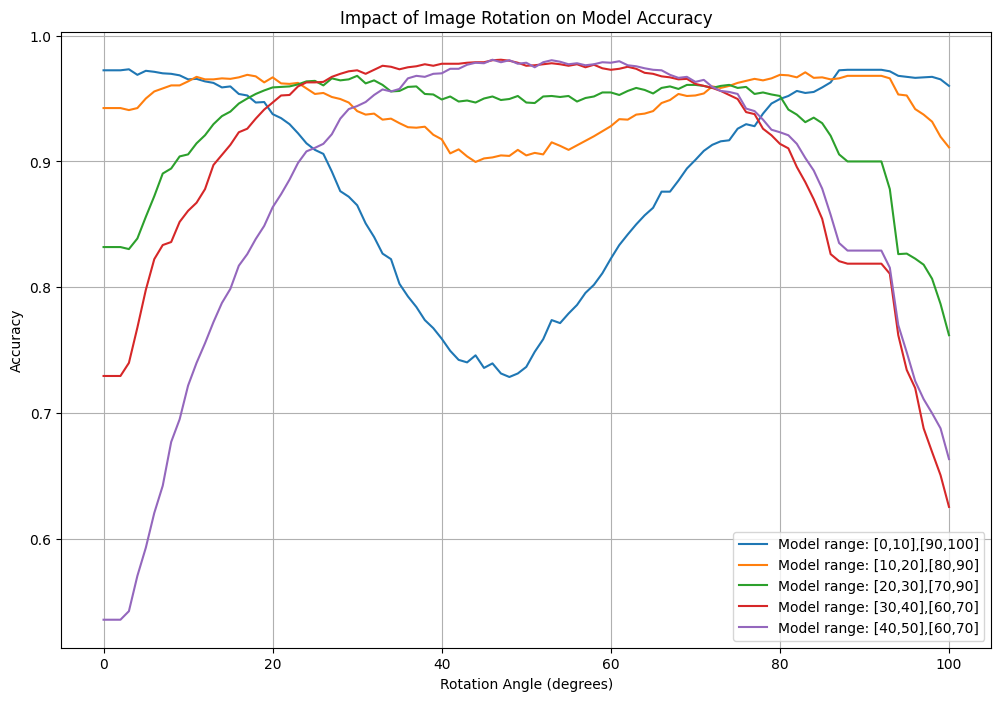

In [110]:
# Create a new figure
plt.figure(figsize=(12, 8))

# List of all your accuracy results
all_results = [
    accuracy_resultsX1, accuracy_resultsX2, accuracy_resultsX3,
    accuracy_resultsX4, accuracy_resultsX5
]

# Plot each one
labels = ['Model range: [0,10],[90,100]', 'Model range: [10,20],[80,90]', 'Model range: [20,30],[70,90]', 
          'Model range: [30,40],[60,70]', 'Model range: [40,50],[60,70]']

for i, results in enumerate(all_results):
    rotations = list(results.keys())
    accuracies = list(results.values())
    plt.plot(rotations, accuracies, label=labels[i])

plt.xlabel('Rotation Angle (degrees)')
plt.ylabel('Accuracy')
plt.title('Impact of Image Rotation on Model Accuracy')
plt.legend()
plt.grid(True)
plt.show()

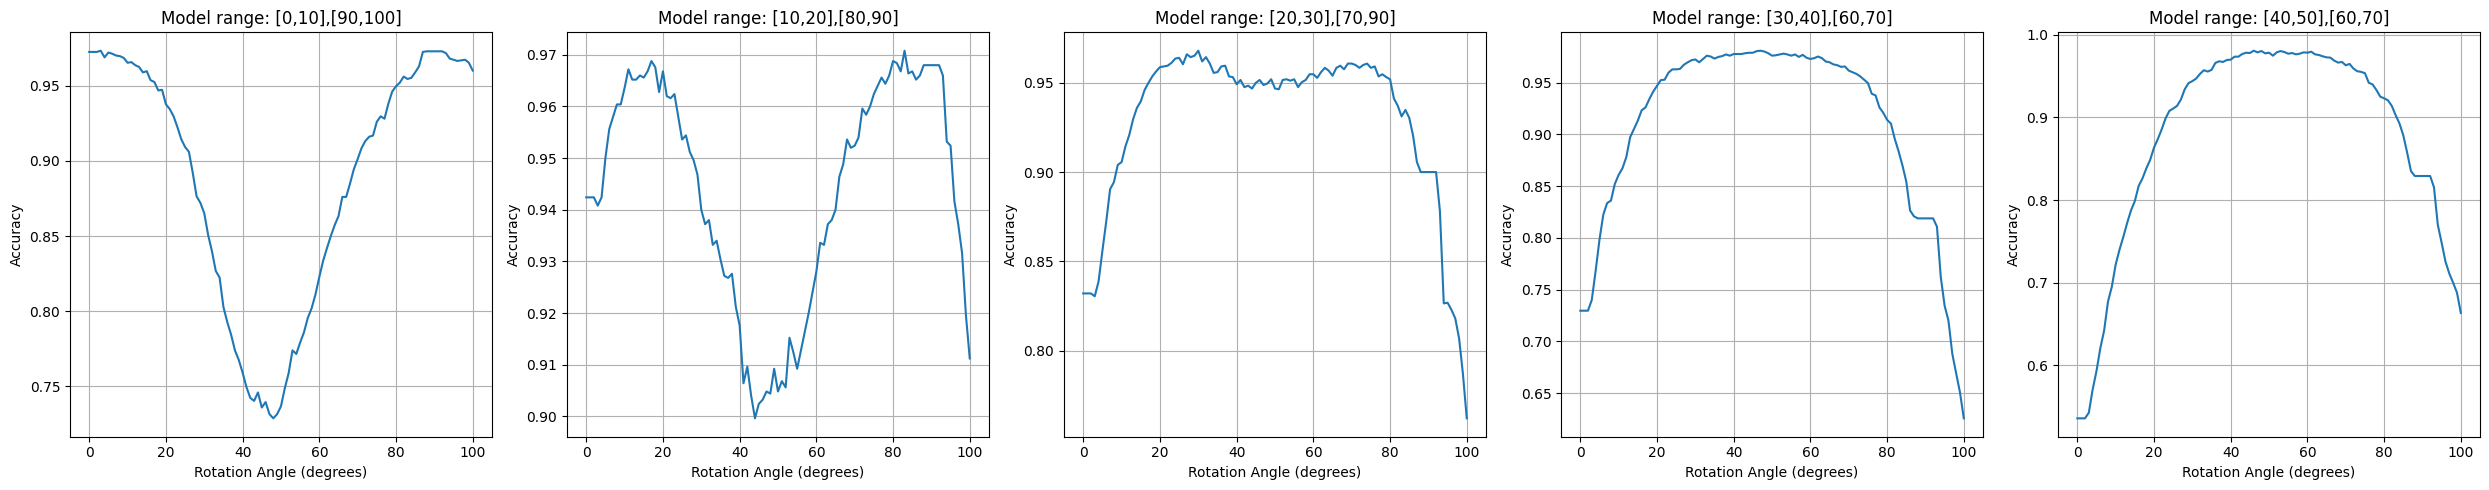

In [112]:
# List of all your accuracy results and their labels
all_results = [
    accuracy_resultsX1, accuracy_resultsX2, accuracy_resultsX3,
    accuracy_resultsX4, accuracy_resultsX5
]
labels = ['Model range: [0,10],[90,100]', 'Model range: [10,20],[80,90]', 'Model range: [20,30],[70,90]', 
          'Model range: [30,40],[60,70]', 'Model range: [40,50],[60,70]']


# Create a 2x5 grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each dataset in its own subplot
for i, (results, label) in enumerate(zip(all_results, labels)):
    rotations = list(results.keys())
    accuracies = list(results.values())

    axes[i].plot(rotations, accuracies)
    axes[i].set_title(label)
    axes[i].set_xlabel('Rotation Angle (degrees)')
    axes[i].set_ylabel('Accuracy')
    axes[i].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [129]:
angleXX1 = list()
transX1 = list()
X_temp = list()
for i in range(0,X_train.shape[0]):
    unknown = int(random.uniform(1,3))
    if unknown ==1:
        angle = int(random.uniform(0,100))
        X_temp.append(rotate(X_train[i],angle,preserve_range=True, order=0))
        angleXX1.append(angle)
    elif unknown ==2:
        trans = int(random.uniform(1,15))
        X_temp.append(np.roll(X_train[i], shift=trans, axis=1))
        transX1.append(trans)
X_trainXX1 = np.array(X_temp).reshape(-1, 28, 28, 1)

In [143]:
modelXX1 = build_smallnet()
historyXX1 = modelXX1.fit(X_trainXX1, y_train, epochs=5, batch_size=64, validation_split=0.2)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6985 - loss: 0.9178 - val_accuracy: 0.9322 - val_loss: 0.2276
Epoch 2/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9434 - loss: 0.1808 - val_accuracy: 0.9572 - val_loss: 0.1456
Epoch 3/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9630 - loss: 0.1188 - val_accuracy: 0.9582 - val_loss: 0.1352
Epoch 4/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9717 - loss: 0.0893 - val_accuracy: 0.9657 - val_loss: 0.1165
Epoch 5/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9783 - loss: 0.0698 - val_accuracy: 0.9679 - val_loss: 0.1118


In [144]:
accuracy_resultsXX1_1 = evaluate_rotation_impact(modelXX1, X_test[:2500], y_test[:2500])

In [147]:
translation_results = evaluate_translation_impact(model=modelXX1, X_test=X_test[:2500], y_test=y_test[:2500])

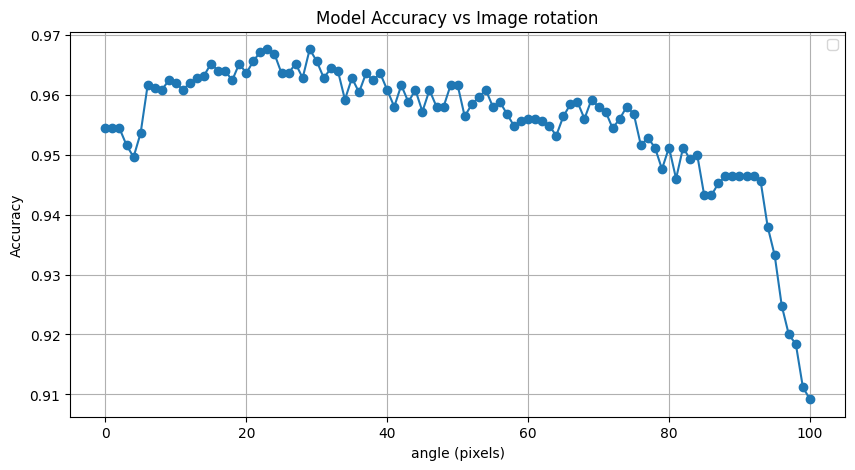

In [152]:

plt.figure(figsize=(10, 5))
plt.plot(accuracy_resultsXX1_1.keys(), accuracy_resultsXX1_1.values(), marker='o')
#plt.axhline(y=0.9, color='r', linestyle='--', label='90% Accuracy Threshold')
plt.xlabel('angle (pixels)')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs Image rotation')
plt.legend()
plt.grid(True)
plt.show()

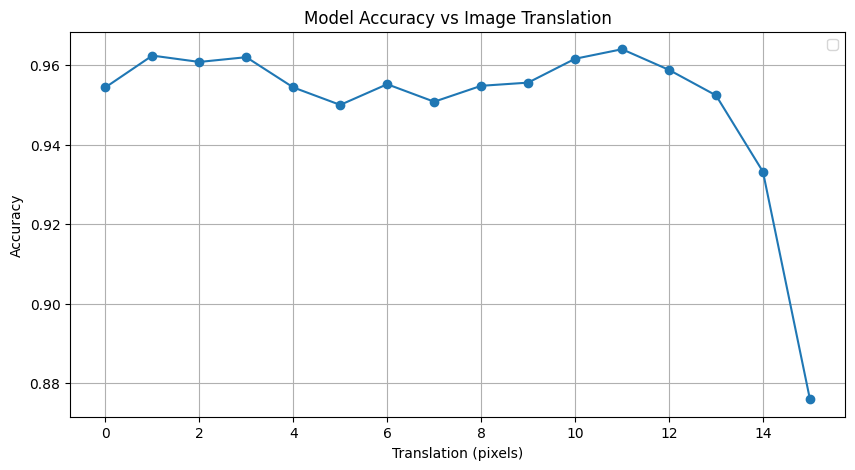

In [153]:
plt.figure(figsize=(10, 5))
plt.plot(translation_results.keys(), translation_results.values(), marker='o')
#plt.axhline(y=0.9, color='r', linestyle='--', label='90% Accuracy Threshold')
plt.xlabel('Translation (pixels)')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs Image Translation')
plt.legend()
plt.grid(True)
plt.show()

(array([10629., 10712.,  8706.,     0.,     0.,     0.,     0.,     0.,
        14918., 15035.]),
 array([ 1. ,  5.8, 10.6, 15.4, 20.2, 25. , 29.8, 34.6, 39.4, 44.2, 49. ]),
 <BarContainer object of 10 artists>)

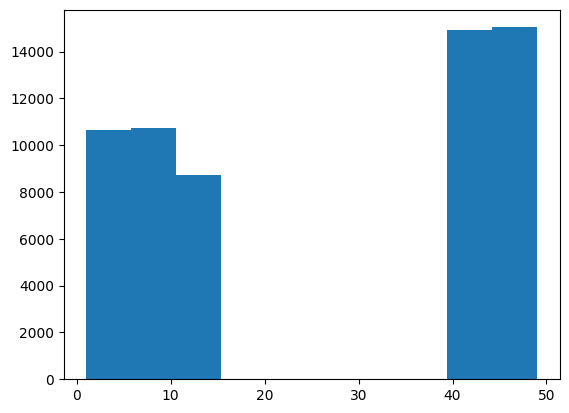

In [123]:
plt.hist(angleXX)

(array([4287., 2142., 2144., 4257., 2038., 2143., 4388., 2064., 2156.,
        4325.]),
 array([ 1. ,  2.3,  3.6,  4.9,  6.2,  7.5,  8.8, 10.1, 11.4, 12.7, 14. ]),
 <BarContainer object of 10 artists>)

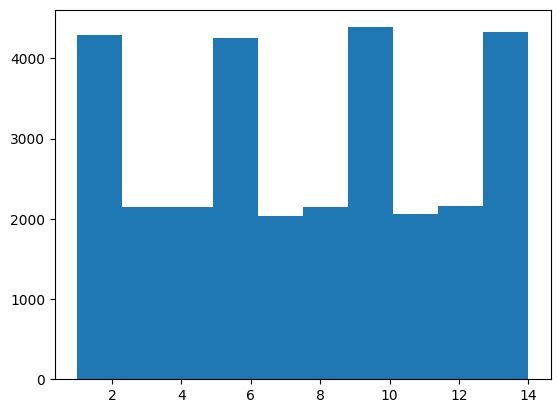

In [127]:
plt.hist(transX)

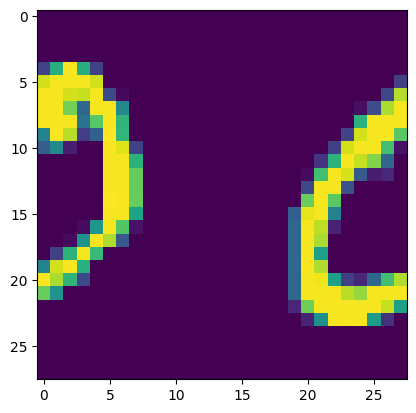

In [124]:
plt.imshow(X_trainXX[1])

In [ ]:
# ----------------------------
# 3. Rotation Accuracy Evaluator
# ----------------------------
def evaluate_rotation_impact(model, X_test, y_test, max_angle=100, step=1):
    """
    Evaluates model accuracy across rotation angles (0° to max_angle).
    
    Args:
        model: Trained Keras model
        X_test: Test images
        y_test: Test labels
        max_angle: Maximum rotation angle (default: 100°)
        step: Angle increment step (default: 1°)
    
    Returns:
        results: Dictionary {angle: accuracy}
        critical_angle: First angle where accuracy drops below 90%
    """
    angles = range(0, max_angle + 1, step)
    results = {}
    critical_angle = None
    
    for angle in angles:
        # Rotate images with nearest-neighbor interpolation
        X_rotated = np.array([rotate(img.squeeze(), angle, order=0, preserve_range=True) 
                             for img in X_test])
        X_rotated = X_rotated.reshape(-1, 28, 28, 1)
        
        # Evaluate accuracy
        _, acc = model.evaluate(X_rotated, y_test, verbose=0)
        results[angle] = acc
    
    return results

In [ ]:
angleX = list()
X_temp = list()
for i in range(0,X_train.shape[0]):
    unknown = int(random.uniform(1,3))
    if unknown ==1:
        angle = int(random.uniform(0,10))
    elif unknown ==2:
        angle = int(random.uniform(90,100))
    X_temp.append(rotate(X_train[i],angle,preserve_range=True, order=0))
    angleX.append(angle)
X_trainX = np.array(X_temp).reshape(-1, 28, 28, 1)

In [ ]:
modelX = build_smallnet()
historyX = modelX.fit(X_trainX, y_train, epochs=5, batch_size=64, validation_split=0.2)

In [ ]:
accuracy_resultsX = evaluate_rotation_impact(modelX, X_test0, y_test[:2500])

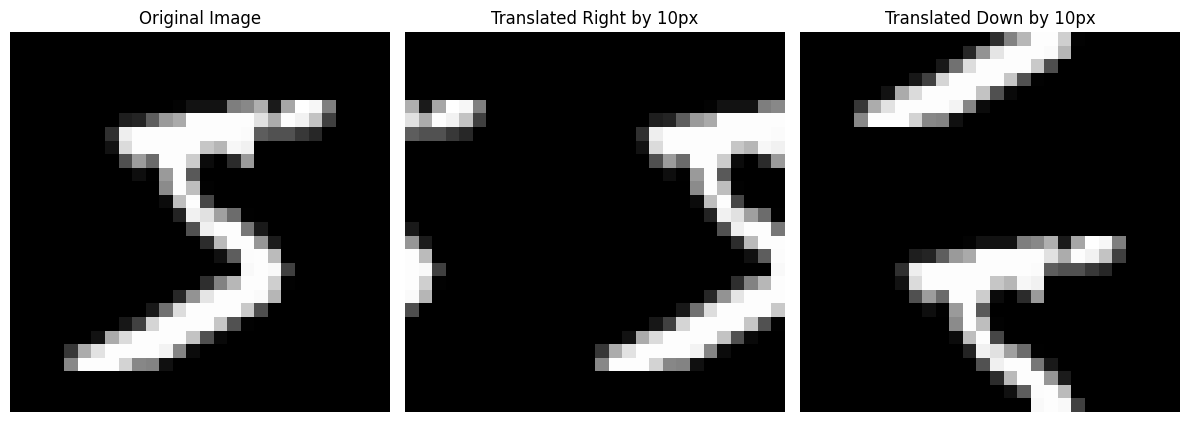

In [113]:
import numpy as np
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

def translate_image(image, dx=0, dy=0):
    """
    Translate an image with wrap-around (cyclic translation).
    
    Parameters:
    - image: 2D numpy array (28x28 for MNIST)
    - dx: Number of pixels to shift horizontally (positive = right, negative = left)
    - dy: Number of pixels to shift vertically (positive = down, negative = up)
    
    Returns:
    - Translated image with same shape as input
    """
    # For MNIST, we don't need to handle channels, but if you had RGB:
    if len(image.shape) > 2:
        translated = np.zeros_like(image)
        for channel in range(image.shape[2]):
            translated[:, :, channel] = np.roll(image[:, :, channel], shift=(dy, dx), axis=(0, 1))
        return translated
    else:
        return np.roll(image, shift=(dy, dx), axis=(0, 1))

# Example usage with MNIST
def demonstrate_translation():
    # Load MNIST data
    (train_images, _), (_, _) = mnist.load_data()
    
    # Select a sample image
    sample_image = train_images[0]
    
    # Create figure
    plt.figure(figsize=(12, 6))
    
    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(sample_image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    # Translated right by 10 pixels (with wrap-around)
    plt.subplot(1, 3, 2)
    translated_right = translate_image(sample_image, dx=10, dy=0)
    plt.imshow(translated_right, cmap='gray')
    plt.title('Translated Right by 10px')
    plt.axis('off')
    
    # Translated down by 10 pixels (with wrap-around)
    plt.subplot(1, 3, 3)
    translated_down = translate_image(sample_image, dx=0, dy=10)
    plt.imshow(translated_down, cmap='gray')
    plt.title('Translated Down by 10px')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Run the demonstration
demonstrate_translation()

# Angle [0,30] and [120,150]

In [ ]:
def find_rotation_threshold(model, X_test, y_test, max_angle=180,loss_increase_threshold=0.1):
    """
    Automatically finds the rotation angle where loss increases by >10%.
    Args:
        model: Trained Keras model
        X_test: Test images
        y_test: Test labels
        max_angle: Maximum angle to test (default: 360°)
        loss_increase_threshold: Allowed loss increase (default: 10%)
    Returns:
        angle_limit: First angle where loss exceeds threshold
        losses: Dictionary of angles and corresponding losses
    """
    # Baseline loss at 0°
    baseline_loss = model.evaluate(X_test, y_test, verbose=0)[0]
    print(f"Baseline loss (0°): {baseline_loss:.4f}")
    
    angle_limit = None
    losses = {0: baseline_loss}
    
    # Iterate angles from 1° to max_angle
    for angle in range(1, max_angle + 1):
        # Rotate images (using nearest-neighbor interpolation for MNIST digits)
        X_rotated = np.array([rotate(img.squeeze(), angle, preserve_range=True, order=0) 
                             for img in X_test])
        X_rotated = X_rotated.reshape(-1, 28, 28, 1)
        
        # Evaluate loss
        current_loss = model.evaluate(X_rotated, y_test, verbose=0)[0]
        losses[angle] = current_loss
        
        # Check for >10% loss increase
        if current_loss > baseline_loss * (1 + loss_increase_threshold):
            angle_limit = angle
            print(f"\n⚠️ Loss increased by >10% at {angle}° (Loss: {current_loss:.4f})")
            break
            
        # Print progress
        if angle % 1 == 0:
            print(f"Angle {angle}°: Loss = {current_loss:.4f}")
    
    if angle_limit is None:
        print(f"No angle ≤{max_angle}° exceeded the loss threshold.")
    
    return angle_limit, losses

In [ ]:
angle_limit, losses = find_rotation_threshold(model, X_test, y_test)

In [ ]:
def plot_loss_progression(losses, angle_limit):
    angles = list(losses.keys())
    loss_values = list(losses.values())
    baseline_loss = losses[0]
    
    plt.figure(figsize=(10, 5))
    plt.plot(angles, loss_values, 'b-', label='Test Loss')
    plt.axhline(y=baseline_loss * 1.1, color='r', linestyle='--', 
                label='10% Loss Increase Threshold')
    
    if angle_limit is not None:
        plt.axvline(x=angle_limit, color='g', linestyle='--', 
                    label=f'Critical Angle: {angle_limit}°')
    
    plt.xlabel('Rotation Angle (degrees)')
    plt.ylabel('Loss')
    plt.title('Loss vs. Image Rotation Angle')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss_progression(losses, angle_limit)

In [ ]:
def find_accuracy_threshold(model, X_test, y_test, epochs, max_angle=360, accuracy_threshold=0.85):
    """
    Finds the rotation angle where accuracy drops below a specified threshold.
    Args:
        model: Trained Keras model
        X_test: Test images
        y_test: Test labels
        max_angle: Maximum angle to test (default: 360°)
        accuracy_threshold: Minimum allowed accuracy (e.g., 0.9 = 90%)
    Returns:
        angle_limit: First angle where accuracy < threshold
        accuracies: Dictionary of angles and corresponding accuracies
    """
    # Baseline accuracy at 0°
    baseline_accuracy = model.evaluate(X_test, y_test, epochs, verbose=0)[1]
    print(f"Baseline accuracy (0°): {baseline_accuracy:.4f}")
    
    angle_limit = None
    accuracies = {0: baseline_accuracy}
    
    # Iterate angles from 1° to max_angle
    for angle in range(1, max_angle + 1):
        # Rotate images (use nearest-neighbor interpolation for MNIST digits)
        X_rotated = np.array([rotate(img.squeeze(), angle, preserve_range=True, order=0) 
                             for img in X_test])
        X_rotated = X_rotated.reshape(-1, 28, 28, 1)
        
        # Evaluate accuracy
        current_accuracy = model.evaluate(X_rotated, y_test, epochs, verbose=0)[1]
        accuracies[angle] = current_accuracy
        
        # Check if accuracy drops below threshold
        if current_accuracy < accuracy_threshold:
            angle_limit = angle
            print(f"\n⚠️ Accuracy dropped below {accuracy_threshold*100}% at {angle}° (Accuracy: {current_accuracy:.4f})")
            break
            
        # Print progress every 1°
        if angle % 1 == 0:
            print(f"Angle {angle}°: Accuracy = {current_accuracy:.4f}")
    
    if angle_limit is None:
        print(f"No angle ≤{max_angle}° caused accuracy to drop below {accuracy_threshold*100}%.")
    
    return angle_limit, accuracies

In [ ]:
angle_limit, accuracies = find_accuracy_threshold(model, X_test, y_test, 10,accuracy_threshold=0.85)

In [ ]:
def plot_accuracy_progression(accuracies, angle_limit, threshold=0.85):
    angles = list(accuracies.keys())
    accuracy_values = list(accuracies.values())
    
    plt.figure(figsize=(10, 5))
    plt.plot(angles, accuracy_values, 'b-', label='Test Accuracy')
    plt.axhline(y=threshold, color='r', linestyle='--', 
                label=f'{threshold*100}% Accuracy Threshold')
    
    if angle_limit is not None:
        plt.axvline(x=angle_limit, color='g', linestyle='--', 
                    label=f'Critical Angle: {angle_limit}°')
    
    plt.xlabel('Rotation Angle (degrees)')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Image Rotation Angle')
    plt.ylim(0, 1.0)  # Accuracy ranges from 0 to 1
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
plot_accuracy_progression(accuracies, angle_limit)

# Curve explained

The red dotted line is the threshold I set. The blue line represent the decrease in the accuracy and the Green dotted line point the angle which falls below the limit.

# Shifted images

In [ ]:
def shift_left(image, n_pixels):
    """Shift image left by `n_pixels`, filling empty space with zeros."""
    shifted = np.roll(image, shift=-n_pixels, axis=1)  # Shift left along width (axis=1)
    shifted[:, -n_pixels:] = 0  # Fill the rightmost columns with zeros
    return shifted

In [ ]:
def find_shift_threshold(model, X_test, y_test, max_shift=28, accuracy_threshold=0.9):
    """
    Finds the shift (in pixels) where accuracy drops below a specified threshold.
    Args:
        model: Trained Keras model
        X_test: Test images (shape: [num_samples, 28, 28, 1])
        y_test: Test labels
        max_shift: Maximum pixels to shift (default: 28, full image width)
        accuracy_threshold: Minimum allowed accuracy (e.g., 0.9 = 90%)
    Returns:
        shift_limit: First shift where accuracy < threshold
        accuracies: Dictionary of shifts and corresponding accuracies
    """
    # Baseline accuracy at 0 shift
    baseline_accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
    print(f"Baseline accuracy (0 pixels shifted): {baseline_accuracy:.4f}")
    
    shift_limit = None
    accuracies = {0: baseline_accuracy}
    
    # Iterate shifts from 1 to max_shift
    for shift in range(1, max_shift + 1):
        # Shift all test images left by `shift` pixels
        X_shifted = np.array([shift_left(img.squeeze(), shift) for img in X_test])
        X_shifted = X_shifted.reshape(-1, 28, 28, 1)
        
        # Evaluate accuracy
        current_accuracy = model.evaluate(X_shifted, y_test, verbose=0)[1]
        accuracies[shift] = current_accuracy
        
        # Check if accuracy drops below threshold
        if current_accuracy < accuracy_threshold:
            shift_limit = shift
            print(f"\n⚠️ Accuracy dropped below {accuracy_threshold*100}% at {shift} pixels (Accuracy: {current_accuracy:.4f})")
            break
            
        # Print progress every 2 pixels
        if shift % 2 == 0:
            print(f"Shift {shift} pixels: Accuracy = {current_accuracy:.4f}")
    
    if shift_limit is None:
        print(f"No shift ≤{max_shift} pixels caused accuracy to drop below {accuracy_threshold*100}%.")
    
    return shift_limit, accuracies

In [ ]:
shift_limit, accuracies = find_shift_threshold(model, X_test, y_test)

In [ ]:
def plot_shift_accuracy(accuracies, shift_limit, threshold=0.9):
    shifts = list(accuracies.keys())
    accuracy_values = list(accuracies.values())
    
    plt.figure(figsize=(10, 5))
    plt.plot(shifts, accuracy_values, 'bo-', label='Test Accuracy')
    plt.axhline(y=threshold, color='r', linestyle='--', 
                label=f'{threshold*100}% Accuracy Threshold')
    
    if shift_limit is not None:
        plt.axvline(x=shift_limit, color='g', linestyle='--', 
                    label=f'Critical Shift: {shift_limit} pixels')
    
    plt.xlabel('Pixels Shifted Left')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Image Translation (Left Shift)')
    plt.ylim(0, 1.0)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_shift_accuracy(accuracies, shift_limit)

In [ ]:
def show_shifted_examples(X_test, y_test, shifts=[0, 5, 10], num_examples=3):
    for shift in shifts:
        plt.figure(figsize=(10, 2))
        plt.suptitle(f'Shifted Left by {shift} Pixels', y=1.05)
        for i in range(num_examples):
            shifted_img = shift_left(X_test[i].squeeze(), shift)
            pred = model.predict(shifted_img.reshape(1, 28, 28, 1)).argmax()
            true_label = y_test[i].argmax()
            
            plt.subplot(1, num_examples, i+1)
            plt.imshow(shifted_img, cmap='gray')
            plt.title(f"True: {true_label}\nPred: {pred}")
            plt.axis('off')
        plt.show()

show_shifted_examples(X_test, y_test)

In [ ]:
def find_shift_threshold_2(model, X_test, y_test, epochs, max_shift=28, accuracy_threshold=0.9):
    """
    Finds the shift (in pixels) where accuracy drops below a specified threshold.
    Args:
        model: Trained Keras model
        X_test: Test images (shape: [num_samples, 28, 28, 1])
        y_test: Test labels
        max_shift: Maximum pixels to shift (default: 28, full image width)
        accuracy_threshold: Minimum allowed accuracy (e.g., 0.9 = 90%)
    Returns:
        shift_limit: First shift where accuracy < threshold
        accuracies: Dictionary of shifts and corresponding accuracies
    """
    # Baseline accuracy at 0 shift
    baseline_accuracy = model.evaluate(X_test, y_test, epochs, verbose=0)[1]
    print(f"Baseline accuracy (0 pixels shifted): {baseline_accuracy:.4f}")
    
    shift_limit = None
    accuracies = {0: baseline_accuracy}
    
    # Iterate shifts from 1 to max_shift
    for shift in range(1, max_shift + 1):
        # Shift all test images left by `shift` pixels
        X_shifted = np.array([shift_left(img.squeeze(), shift) for img in X_test])
        X_shifted = X_shifted.reshape(-1, 28, 28, 1)
        
        # Evaluate accuracy
        current_accuracy = model.evaluate(X_shifted, y_test, epochs,verbose=0)[1]
        accuracies[shift] = current_accuracy
        
        # Check if accuracy drops below threshold
        if current_accuracy < accuracy_threshold:
            shift_limit = shift
            print(f"\n⚠️ Accuracy dropped below {accuracy_threshold*100}% at {shift} pixels (Accuracy: {current_accuracy:.4f})")
            break
            
        # Print progress every 2 pixels
        if shift % 2 == 0:
            print(f"Shift {shift} pixels: Accuracy = {current_accuracy:.4f}")
    
    if shift_limit is None:
        print(f"No shift ≤{max_shift} pixels caused accuracy to drop below {accuracy_threshold*100}%.")
    
    return shift_limit, accuracies

In [ ]:
shift_limit_2, accuracies_2 = find_shift_threshold_2(model, X_test, y_test, epochs=10)

In [ ]:
plot_shift_accuracy(accuracies_2, shift_limit_2)

In [ ]:
# Train for 5 epochs (adjust based on your needs)
history = model.fit(
    X_train, y_train,
    epochs=5,                # Number of training passes over the dataset
    batch_size=64,           # Mini-batch size for efficient training
    validation_split=0.2     # Use 20% of training data for validation
)

In [ ]:
def test_rotation_impact(model, X_test, y_test, angles=[0, 15, 30, 45, 90]):
    """Test model accuracy on rotated images at specified angles."""
    results = {}
    for angle in angles:
        # Rotate each test image by the current angle (preserve pixel range [0, 1])
        X_rotated = np.array([rotate(img.squeeze(), angle, preserve_range=True) for img in X_test])
        X_rotated = X_rotated.reshape(-1, 28, 28, 1)  # Reshape for model input
        
        # Evaluate model on rotated images
        loss, accuracy = model.evaluate(X_rotated, y_test, verbose=0)
        results[angle] = accuracy
        print(f"Rotation {angle}° \t→ Test Accuracy: {accuracy:.4f}")
    
    return results

In [ ]:
# Test rotation angles and store results
rotation_results = test_rotation_impact(model, X_test, y_test)

In [ ]:
# Plot accuracy vs. rotation angle
plt.figure(figsize=(10, 5))
plt.plot(rotation_results.keys(), rotation_results.values(), 'bo-', linewidth=2, markersize=8)
plt.title("Impact of Image Rotation on Classification Accuracy", fontsize=14)
plt.xlabel("Rotation Angle (degrees)", fontsize=12)
plt.ylabel("Test Accuracy", fontsize=12)
plt.ylim(0, 1.0)  # Accuracy ranges from 0 to 1
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(list(rotation_results.keys()))
plt.show()

In [ ]:
def show_rotated_predictions(X_test, y_test, angles=[0, 30, 90], num_examples=5):
    """Display rotated images with true/predicted labels."""
    for angle in angles:
        plt.figure(figsize=(12, 3))
        plt.suptitle(f"Rotation: {angle}°", fontsize=14, y=1.05)
        
        for i in range(num_examples):
            # Rotate the i-th test image
            rotated_img = rotate(X_test[i].squeeze(), angle, preserve_range=True)
            
            # Reshape for model prediction (add batch dimension)
            pred_prob = model.predict(rotated_img.reshape(1, 28, 28, 1))
            pred_label = np.argmax(pred_prob)
            
            # Get true label from one-hot encoding
            true_label = np.argmax(y_test[i])
            
            # Plot the rotated image
            plt.subplot(1, num_examples, i+1)
            plt.imshow(rotated_img, cmap='gray')
            plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()

In [ ]:
# Display examples rotated at 0°, 30°, and 90°
show_rotated_predictions(X_test, y_test)